In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import pandas as pd
from patsy import dmatrices
import statsmodels.api as sm 

In [2]:
def max_accuracy(accuracies, diagonal = True):
    """
    Return the maximum accuracy for each session.
    """
    # average over folds
    avg = np.mean(accuracies, axis=1)

    acc_max = []
    for i in range(avg.shape[0]): # looping over sessions
        if diagonal:
            max_acc = np.max(avg[i].diagonal())
        else:
            max_acc = np.max(avg[i])
        acc_max.append(max_acc)
    
    return acc_max

In [3]:
lbo_file = 'accuracies_LDA_lbo'
lbo = np.load(f'accuracies/{lbo_file}.npy')

propb_file = 'accuracies_LDA_prop'
propb = np.load(f'accuracies/{propb_file}.npy')

lbo_acc = max_accuracy(lbo, diagonal = False)
propb_acc = max_accuracy(propb, diagonal = False)

In [4]:
# standard deviation within session
std_sessions = np.load('../ERF_analysis/std_sessions.npy')
# average over timepoints
std_sessions = np.mean(std_sessions, axis=1)

In [5]:
### preparing design matrix ###
strategy = np.array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1])
accuracy = np.array(lbo_acc + propb_acc)
std = np.concatenate([std_sessions, std_sessions])

# create the design matrix
design = pd.DataFrame({'strategy': strategy, 'std': std, 'accuracy': accuracy})

y, X = dmatrices('accuracy ~ strategy + std + strategy:std', design)

In [6]:
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

/usr/local/share/anaconda3/envs/mne/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               accuracy   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     2.674
Date:                Mon, 12 Dec 2022   Prob (F-statistic):              0.104
Time:                        17:36:20   Log-Likelihood:                 42.623
No. Observations:                  14   AIC:                            -77.25
Df Residuals:                      10   BIC:                            -74.69
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.8482      0.099      8.585      0.000       0.628       1.068
strategy         0.0085      0.140      0.061      0.953      -0.303       0.320
std             -5.6189      2.947     -1.907      0.086     -12.184       0.947
strategy:std    -0.3648      4.167     -0.088      0.932      -9.650       8.920
==============================================================================
Omnibus:                        0.904   Durbin-Watson:                   1.687
Prob(Omnibus):                  0.636   Jarque-Bera (JB):                0.350
Skew:                          -0.383   Prob(JB):                        0.840
Kurtosis:                       2.881   Cond. No.                     1.50e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.5e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# playground aka mess!!!

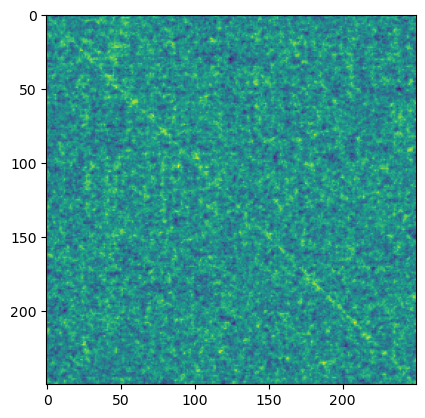

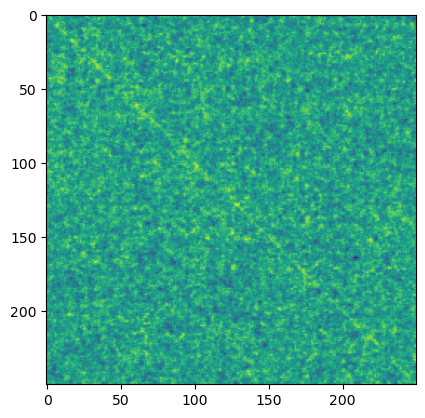

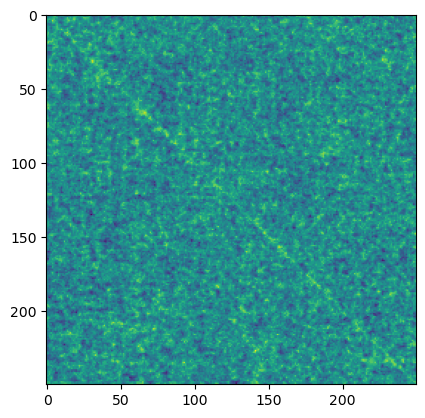

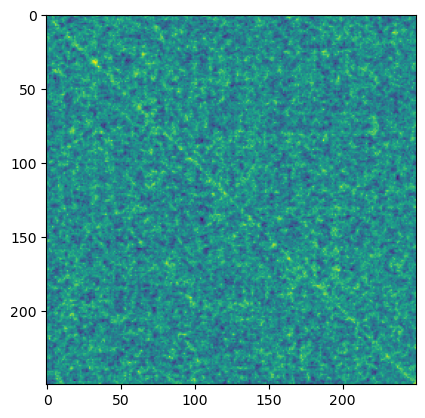

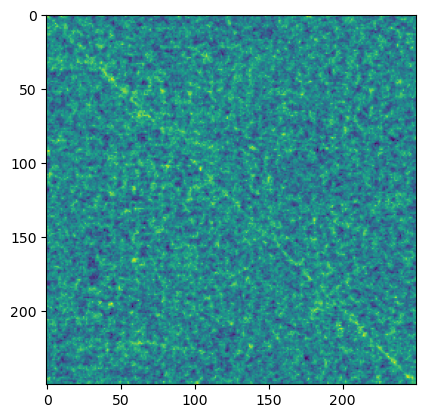

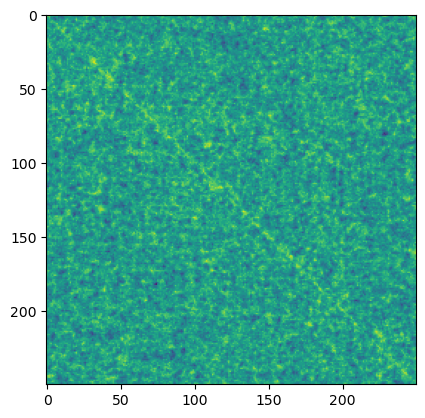

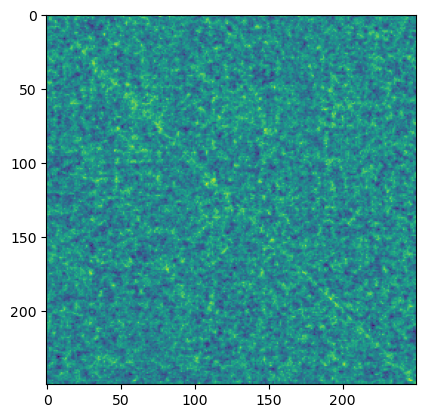

: 

In [103]:
props = np.load('./accuracies/accuracies_LDA_props.npy', allow_pickle=True).squeeze() # proportional session

for i in range(len(props)):
    plt.imshow(props[i], cmap='viridis')
    plt.show()